In [1]:
import numpy as np
import cupy as cp
from holotomocupy.holo import G, GT
from holotomocupy.shift import S, ST
from holotomocupy.chunking import gpu_batch
from holotomocupy.recon_methods import CTFPurePhase, multiPaganin
from holotomocupy.proc import dai_yuan, linear
import holotomocupy.chunking as chunking
from holotomocupy.utils import *
import h5py
from holotomocupy.proc import remove_outliers




astropy module not found
olefile module not found


# Init data sizes and parametes of the PXM of ID16A

In [2]:
n = 2048  # object size in each dimension

npos = 16  # number of code positions
detector_pixelsize = 3.03751e-6
energy = 33.35  # [keV] xray energy
wavelength = 1.2398419840550367e-09/energy  # [m] wave length
focusToDetectorDistance = 1.28  # [m]
sx0 = 3.7e-4
z1 = np.array([4.584e-3, 4.765e-3, 5.488e-3, 6.9895e-3])[:1]-sx0
z1 = np.tile(z1, [npos])
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
voxelsize = np.abs(detector_pixelsize/magnifications[0]*2048/n)  # object voxel size
# allow padding if there are shifts of the probe
pad = n//8
# sample size after demagnification
ne = n+2*pad

show = True

flg = f'1'
path = f'/data/vnikitin/ESRF/ID16A/SiemensLH_33keV_010nm_holoNfpScan_01/'

## Read data

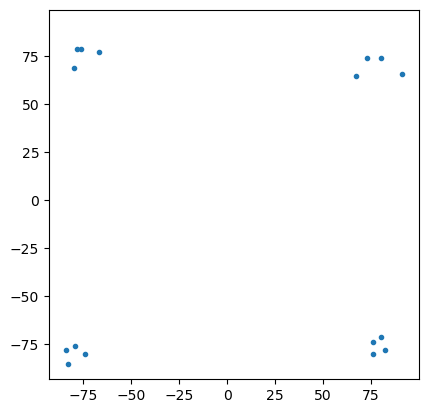

/tmp/ipykernel_879244/560253413.py:42: ComplexWarning: Casting complex values to real discards the imaginary part
  rdata[:,k] = ST(rdata[:,k],shifts_code[:,k])


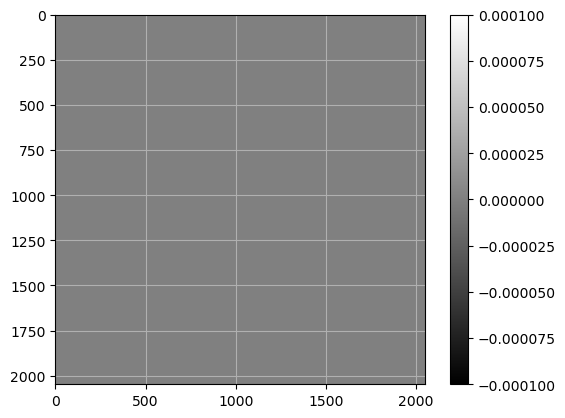

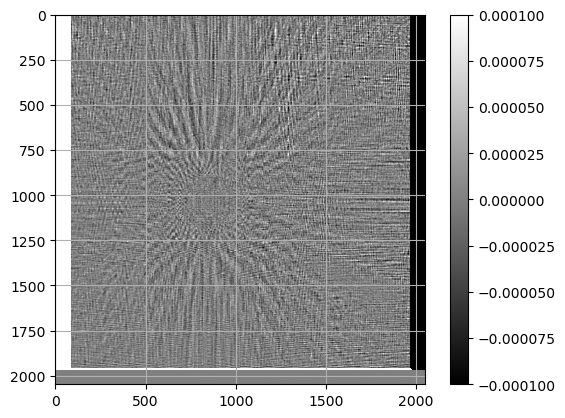

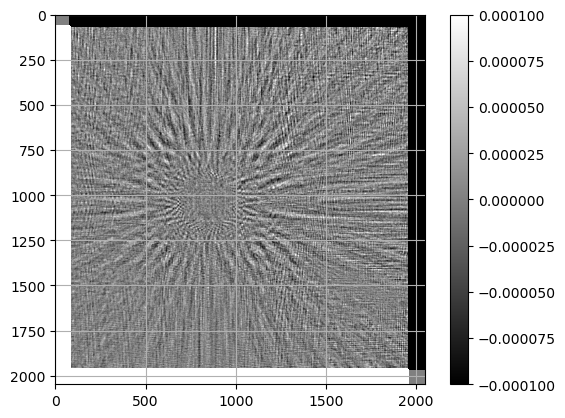

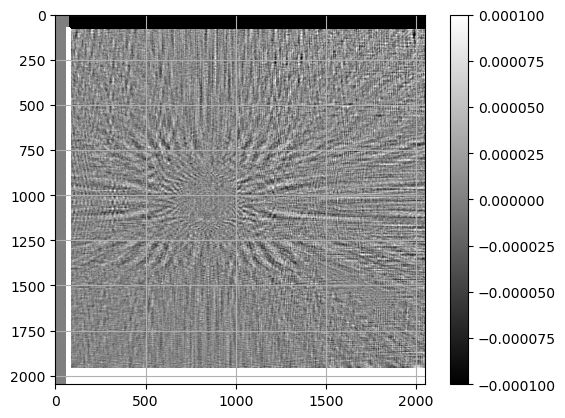

0


In [3]:
nref = 20
ndark = 20
data00 = np.zeros([1,npos,n,n],dtype='float32')
ref00 = np.zeros([nref,n,n],dtype='float32')
dark00 = np.zeros([ndark,n,n],dtype='float32')
with h5py.File(f'{path}SiemensLH_33keV_010nm_holoNfpScan_010000.h5','r') as fid:
    data00[:] = fid['/entry_0000/measurement/data'][:npos][np.newaxis]
with h5py.File(f'{path}/ref_0000.h5','r') as fid:
    ref00[:]=fid['/entry_0000/measurement/data'][:nref]
with h5py.File(f'{path}/dark_0000.h5','r') as fid:
    dark00[:]=fid['/entry_0000/measurement/data'][:ndark]
with h5py.File(f'{path}SiemensLH_33keV_010nm_holoNfpScan_010000.h5','r') as fid:
    spz = np.array(str(np.array(str(np.array(fid['/entry_0000/instrument/PCIe/header/spz']))[1:]))[1:-1].split(' '),dtype='float32')*1e-6/voxelsize
    spy = np.array(str(np.array(str(np.array(fid['/entry_0000/instrument/PCIe/header/spy']))[1:]))[1:-1].split(' '),dtype='float32')*1e-6/voxelsize

plt.plot(spy,spz,'.')
plt.axis('square')
plt.show()
shifts_code = np.zeros([1,npos,2],dtype='float32')
shifts_code[:,:,1] = spy
shifts_code[:,:,0] = -spz

for k in range(npos):
    radius = 7
    threshold = 20000
    data00[:,k] = remove_outliers(data00[:,k], radius, threshold)
ref00[:] = remove_outliers(ref00[:], radius, threshold)     


data00-=np.mean(dark00)
ref00-=np.mean(dark00)

data00[data00<=0] = 0
ref00[ref00<=0] = 0

data00/=np.mean(ref00)
ref00/=np.mean(ref00)

rdata = (data00-np.mean(dark00,axis=0))/(np.mean(ref00,axis=0)-np.mean(dark00,axis=0))

for k in range(npos):
    rdata[:,k] = ST(rdata[:,k],shifts_code[:,k])

for k in range(0,npos,4):
    plt.imshow(rdata[0,k]-rdata[0,0],cmap='gray',vmin=-1e-4,vmax=1e-4)
    plt.grid('on')
    plt.colorbar()
    plt.show()


print(np.sum(np.isnan(data00)))
dxchange.write_tiff(data00[0],'/data/tmp')


# Construct operators


In [7]:
def Lop(psi):
    psi = cp.array(psi)

    data = cp.zeros([psi.shape[0], npos, n, n], dtype='complex64')
    for i in range(npos):
        psir = psi[:,i].copy()       
        psir = G(psir, wavelength, voxelsize, distances[i])
        data[:, i] = psir[:, pad:n+pad, pad:n+pad]
    return data

def LTop(data):
    psi = cp.zeros([data.shape[0],npos, n+2*pad, n+2*pad], dtype='complex64')

    for j in range(npos):
        psir = cp.pad(data[:, j], ((0, 0), (pad, pad), (pad, pad))).astype('complex64')
        psir = GT(psir, wavelength, voxelsize, distances[j])        
        psi[:,j] = psir
    return psi

def Lop2(prb):
    prb = cp.array(prb)
    psir = G(prb, wavelength, voxelsize, distances[0],'symmetric')
    data = psir[:, pad:n+pad, pad:n+pad]
    return data

def LTop2(data):
    data= cp.array(data)
    data = cp.pad(data, ((0, 0), (pad, pad), (pad, pad))).astype('complex64')
    psi = GT(data, wavelength, voxelsize, distances[0],'symmetric')
    return psi

def Sop(psi):
    psi = cp.array(psi)

    data = cp.zeros([psi.shape[0], npos, n+2*pad, n+2*pad], dtype='complex64')
    for i in range(npos):
        psir = psi.copy()
    
        # shift and crop the code 
        psir = S(psir, shifts_code[:, i])
        nee = psir.shape[1]        
        data[:,i] = psir[:, nee//2-n//2-pad:nee//2+n//2+pad, nee//2-n//2-pad:nee//2+n//2+pad]
    return data

def STop(data):
    psi = cp.zeros([data.shape[0], ne, ne], dtype='complex64')

    for j in range(npos):
        psir = cp.pad(data[:,j],((0,0),(ne//2-n//2-pad,ne//2-n//2-pad),(ne//2-n//2-pad,ne//2-n//2-pad)))        
        psi += ST(psir,shifts_code[:,j])
    return psi


data = cp.array(data00)
arr1 = cp.pad(data[:,0],((0,0),(ne//2-n//2,ne//2-n//2),(ne//2-n//2,ne//2-n//2)),'symmetric')     
prb1 = cp.ones([1,n+2*pad,n+2*pad],dtype='complex64')
shifts_code = cp.array(shifts_code)
arr2 = Sop(arr1)
arr3 = STop(arr2)

arr4 = Lop(arr2)
arr5 = LTop(arr4)

arr6 = Lop2(prb1)
arr7 = LTop2(arr6)


print(f'{cp.sum(arr1*cp.conj(arr3))}==\n{cp.sum(arr2*cp.conj(arr2))}')
print(f'{cp.sum(arr2*cp.conj(arr5))}==\n{cp.sum(arr4*cp.conj(arr4))}')
print(f'{cp.sum(prb1*cp.conj(arr7))}==\n{cp.sum(arr6*cp.conj(arr6))}')



(126722432-4.293596267700195j)==
(126722432-2.5500974595860093e-11j)
(83255784-2.875j)==
(83255784+3.055711931665428e-05j)
(4194303.75-0.0029296875j)==
(4194304+0j)


### Divide by reference image for 1step Paganin reconsturction

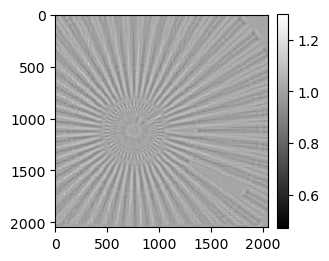

In [5]:
ref0 = cp.array(cp.mean(ref00,axis=0))[np.newaxis,np.newaxis]
data00 = cp.array(data00)
rdata = data00/ref0
mshow((rdata)[0,0],show,vmax=1.3)

/tmp/ipykernel_879244/2228664114.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  recMultiPaganin[:,j] = ST(r,shifts_code[:,j])
/tmp/ipykernel_879244/2228664114.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  recMultiPaganinr[:,j] = ST(rr,shifts_code[:,j])


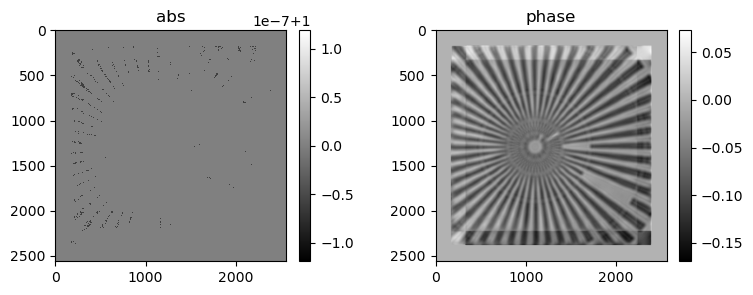

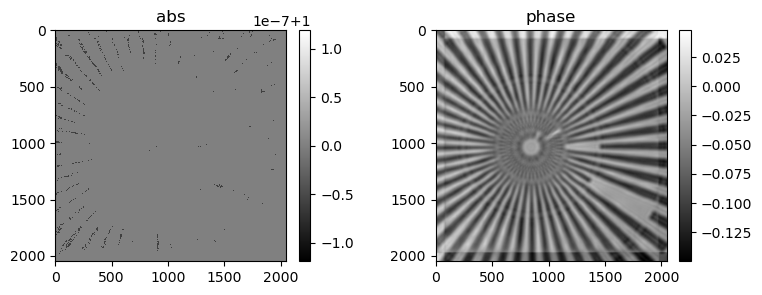

In [6]:
recMultiPaganin = cp.zeros([1,npos,ne,ne],dtype='float32')
recMultiPaganinr = cp.zeros([1,npos,ne,ne],dtype='float32')# to compensate for overlap
for j in range(0,npos):
    r = multiPaganin(rdata[:,j:j+1],
                         distances[j:j+1], wavelength, voxelsize,  24.05, 9e-3)    
    rr = r*0+1 # to compensate for overlap
    r = cp.pad(r,((0,0), (ne//2-n//2,ne//2-n//2), (ne//2-n//2,ne//2-n//2)),'constant')   
    rr = cp.pad(rr,((0,0), (ne//2-n//2,ne//2-n//2), (ne//2-n//2,ne//2-n//2)),'constant')   
    recMultiPaganin[:,j] = ST(r,shifts_code[:,j])
    recMultiPaganinr[:,j] = ST(rr,shifts_code[:,j])
    
recMultiPaganin = cp.sum(recMultiPaganin,axis=1)
recMultiPaganinr = cp.sum(recMultiPaganinr,axis=1)

# avoid division by 0
recMultiPaganinr[np.abs(recMultiPaganinr)<5e-2] = 1

# compensate for overlap
recMultiPaganin /= recMultiPaganinr
recMultiPaganin = cp.exp(1j*recMultiPaganin)

mshow_polar(recMultiPaganin[0],show)
mshow_polar(recMultiPaganin[0,pad:-pad,pad:-pad],show)


#### Reconstruction with the CG (Carlsson) with Hessians

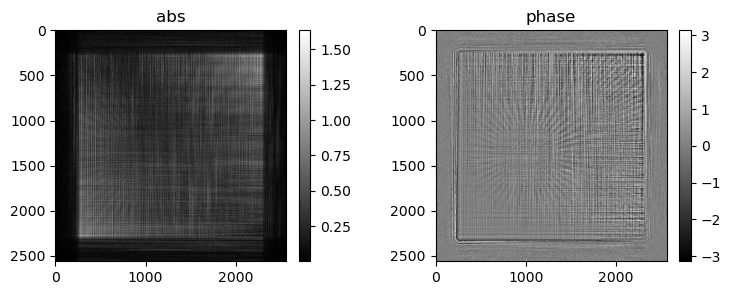

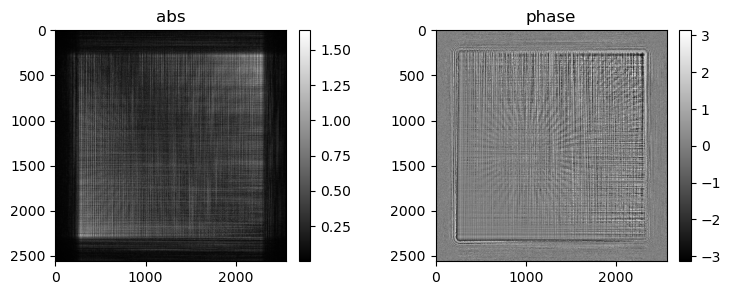

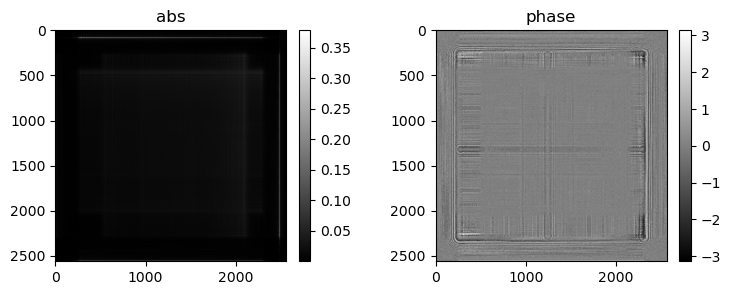

0) gammah=array(0.02001003, dtype=float32), err=4.03013e+05


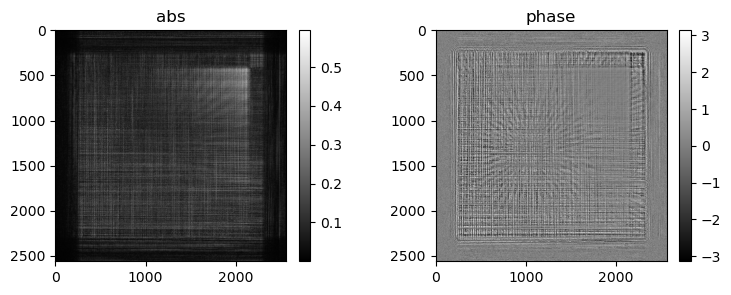

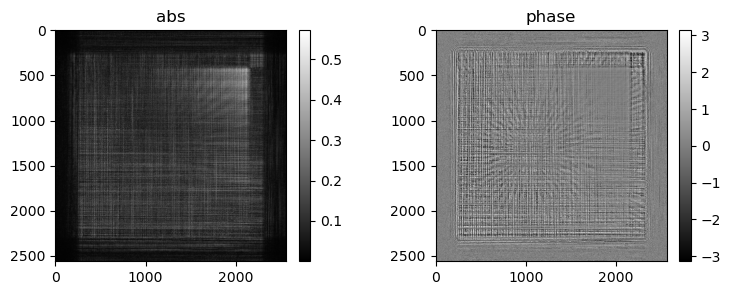

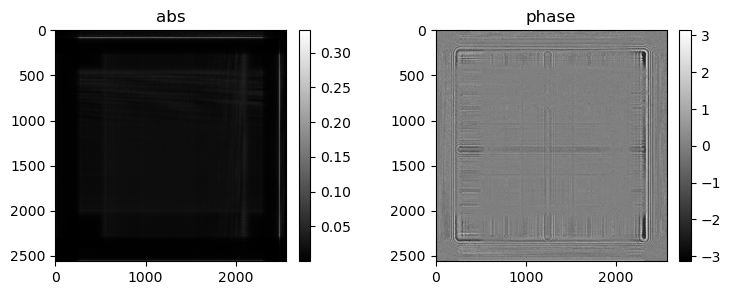

KeyboardInterrupt: 

In [8]:
def hessian2(hpsi,hksi,heta,data):
    Lksi = Lop(hksi)
    Leta = Lop(heta)
    Lpsi = Lop(hpsi)        

    v1 = cp.abs(Lpsi)-data
    v2 = cp.real(cp.conj(Lksi)*Leta)/cp.abs(Lpsi)            
    v3 = cp.real(cp.conj(Lpsi)*Lksi) * cp.real(cp.conj(Lpsi)*Leta) / cp.abs(Lpsi)**3        
    return 2*(cp.sum(v1 * cp.conj(v2)) + cp.sum(data*cp.conj(v3)))

def hessian2(x,y,z,d,prb):
    l0 = cp.exp(1j*np.angle(Lop(Sop(x)*prb)+Lop2(prb)))

    Ly = fwd_holo(y,prb)
    Lz = fwd_holo(z,prb)
    Lq = fwd_holo0(prb)

    d0 = d/cp.abs(Lx+Lq)    
    l0 = Lx/cp.abs(Lx)

    v1 = cp.sum((1-d0)*cp.conj(cp.real(Ly*cp.conj(Lz))))
    v2 = cp.sum(d0*cp.conj(cp.real(cp.conj(l0)*Ly+cp.conj(l0)*Lz))) 
    return 2*(v1+v2)  

def cg_holo(data,ref, init_psi,init_prb,  pars):
    """Conjugate gradients method for holography"""
    def minf(fpsi):
        f = np.linalg.norm(np.abs(fpsi)-data)**2
        return f

    data = np.sqrt(data)
    ref = np.sqrt(ref)

    psi = init_psi.copy()
    prb = init_prb.copy()

    conv = np.zeros(pars['niter'])
    gammaha = np.zeros(pars['niter'])
    
   
        
    for i in range(pars['niter']):                                        
        
        l0 = cp.exp(1j*np.angle(Lop(Sop(psi)*prb)+Lop2(prb)))
        # mshow_polar(fpsi[0,0],show)
        # mshow_polar(fpsi0[0,0],show)
        # mshow_polar(fpsi0[0,0]-fpsi0[0,0],show)

        
        tdata = data*l0-Lop2(prb)
        gradx = 2*LTop(Lop(Sop(psi)*prb)-tdata)


        # mshow_polar(gradx[0,0],show)
        # mshow_polar(gradx0[0,0],show)
        # mshow_polar(gradx[0,0]-gradx0[0,0],show)

        gradpsi = STop(gradx*cp.conj(prb))             

        
        gradprb = gradx*cp.conj(Sop(psi))
        gradprb = cp.sum(gradprb,axis=1)        

#        etapsi = -gradpsi
 #       etaprb = -gradprb
        if i==0:
            etapsi = -gradpsi
            etaprb = -gradprb
        else:
            # top
            hpsi = Sop(psi)*prb            
            hksi = Sop(gradpsi)*prb+Sop(psi)*gradprb   
            heta = Sop(etapsi)*prb+Sop(psi)*etaprb                        

            h2u = hessian2(hpsi,hksi,heta,data)
            h2u += cp.real(cp.sum(gradx*cp.conj(Sop(gradpsi)*etaprb)))+ \
                   cp.real(cp.sum(gradx*cp.conj(Sop(etapsi)*gradprb)))
            
            # bottom
            hpsi = Sop(psi)*prb
            heta = Sop(etapsi)*prb+Sop(psi)*etaprb   
            h2b = hessian2(hpsi,heta,heta,data)
            h2b += 2*cp.real(cp.sum(gradx*cp.conj(Sop(etapsi)*etaprb)))

            beta = h2u/h2b
            
            etapsi = -gradpsi + beta*etapsi
            etaprb = -gradprb + beta*etaprb

        #top
        top = -cp.sum(cp.real(gradpsi*cp.conj(etapsi)))-cp.sum(cp.real(gradprb*cp.conj(etaprb)))
        # bottom
        hpsi = Sop(psi)*prb
        heta = Sop(etapsi)*prb+Sop(psi)*etaprb  
        
        h2b = hessian2(hpsi,heta,heta,data)
        h2b += 2*cp.real(cp.sum(gradx*cp.conj(Sop(etapsi)*etaprb)))
        
        gammah = top/h2b 


        psi += gammah*etapsi
        prb += gammah*etaprb

        if i % pars['err_step'] == 0:
            fpsi = Lop(Sop(psi)*prb)
            err = minf(fpsi)
            conv[i] = err
            gammaha[i] = gammah
            print(f'{i}) {gammah=}, {err=:1.5e}')

        if i % pars['vis_step'] == -1:
            mshow_polar(psi[0],show)
            mshow_polar(psi[0,pad:-pad,pad:-pad],show)
            mshow_polar(prb[0],show)

    return psi,prb,conv,gammaha

# fully on gpu
rec_psi = recMultiPaganin.copy()*0+1
data = cp.array(data00.copy())
ref = cp.array(ref0.copy())

rec_prb = cp.ones([1,n+2*pad,n+2*pad],dtype='complex64')#cp.array(rec_prb0.copy())*0+1#cp.abs(rec_prb0).astype('complex64')#*cp.exp().copy()
pars = {'niter':4, 'err_step': 1, 'vis_step': 1}
rec_psi,rec_prb,conv,gammaha = cg_holo(data,ref,rec_psi,rec_prb, pars)
k = f'cghessiansv2'
np.save(f'data/rec_psi_{k}_{pars['niter']}',rec_psi.get())
np.save(f'data/rec_prb_{k}_{pars['niter']}',rec_prb.get())
np.save(f'data/conv_{k}_{pars['niter']}',conv)
np.save(f'data/gammaha_{k}_{pars['niter']}',gammaha)



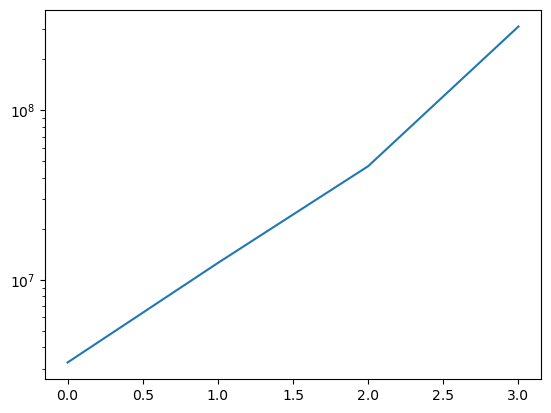

In [8]:
plt.plot(conv)
plt.yscale('log')

In [9]:
k = f'cghessians'
np.save(f'data/rec_psi_{k}_{pars['niter']}',rec_psi.get())
np.save(f'data/rec_prb_{k}_{pars['niter']}',rec_prb.get())
np.save(f'data/conv_{k}_{pars['niter']}',conv)
np.save(f'data/gammaha_{k}_{pars['niter']}',gammaha)

In [10]:
dxchange.write_tiff(np.angle(rec_psi.get()),'/data/tmp/rec_psi',overwrite=True)
dxchange.write_tiff(np.angle(rec_prb.get()),'/data/tmp/rec_prb',overwrite=True)